Epoch 1/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 46s 96ms/step - loss: 0.2188 - learning_rate: 5.0000e-04
Epoch 2/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - loss: 0.1095 - learning_rate: 5.0000e-04
Epoch 3/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - loss: 0.0851 - learning_rate: 5.0000e-04
Epoch 4/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - loss: 0.0680 - learning_rate: 5.0000e-04
Epoch 5/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - loss: 0.0546 - learning_rate: 5.0000e-04
Epoch 6/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - loss: 0.0445 - learning_rate: 5.0000e-04
Epoch 7/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - loss: 0.0388 - learning_rate: 5.0000e-04
Epoch 8/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - loss: 0.0316 - learning_rate: 5.0000e-04
Epoch 9/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 0.0280 - learning_rate: 5.0000e-04
Epoch 10/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - loss: 0.0243 - learning_rate: 5.0000e-04
Epoch 11/70
409/409 ━━━━━━━━

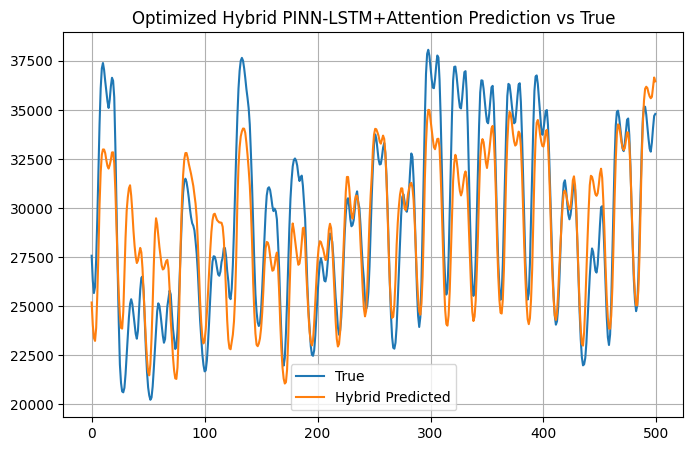

In [1]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Bidirectional, Attention, Concatenate, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# === STEP 1: LOAD AND PREPROCESS DATA ===
weather_df = pd.read_csv('weather_features.csv')
energy_df = pd.read_csv('energy_dataset.csv')

energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True).dt.tz_localize(None)
start_time = energy_df['time'].min()
weather_df['datetime'] = pd.date_range(start=start_time, periods=len(weather_df), freq='h')
merged_df = pd.merge(energy_df, weather_df, left_on='time', right_on='datetime', how='inner')
merged_df = merged_df.drop(columns=['city_name', 'datetime', 'dt_iso'])

# Feature engineering
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['dayofweek'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month
merged_df['year'] = merged_df['time'].dt.year
merged_df['sin_hour'] = np.sin(2 * np.pi * merged_df['hour'] / 24)
merged_df['cos_hour'] = np.cos(2 * np.pi * merged_df['hour'] / 24)
merged_df['sin_month'] = np.sin(2 * np.pi * merged_df['month'] / 12)
merged_df['cos_month'] = np.cos(2 * np.pi * merged_df['month'] / 12)
merged_df['temp_squared'] = merged_df['temp'] ** 2
merged_df['humidity_squared'] = merged_df['humidity'] ** 2

# Smooth load
df = merged_df.copy()
df['total load actual'] = df['total load actual'].rolling(window=5, center=True).mean()
df = df.dropna(subset=['total load actual'])

# Train/test split
df_train = df[df['year'] <= 2017].copy()
df_test = df[df['year'] == 2018].copy()

features = ['t', 'sin_hour', 'cos_hour', 'sin_month', 'cos_month',
            'temp', 'generation solar', 'humidity', 'pressure', 'generation fossil gas',
            'temp_squared', 'humidity_squared']
target = 'total load actual'

# Create time features
df_train['t'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds() / 3600.0
df_test['t'] = (df_test['time'] - df_train['time'].min()).dt.total_seconds() / 3600.0

# Scaling
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_train_np = scaler_X.fit_transform(df_train[features])
y_train_np = scaler_y.fit_transform(df_train[[target]])
X_test_np = scaler_X.transform(df_test[features])
y_test_np = scaler_y.transform(df_test[[target]])

X_train_np = np.nan_to_num(X_train_np)
y_train_np = np.nan_to_num(y_train_np)
X_test_np = np.nan_to_num(X_test_np)
y_test_np = np.nan_to_num(y_test_np)

X_train = torch.tensor(X_train_np, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

# === STEP 2: DEFINE PINN ===
class PINNDeluxe(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super(PINNDeluxe, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.alpha = nn.Parameter(0.01 * torch.randn(input_dim - 1, 1))
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

def physics_loss(x, y_pred, model):
    dload_dt = torch.autograd.grad(
        y_pred, x,
        grad_outputs=torch.ones_like(y_pred),
        retain_graph=True,
        create_graph=True
    )[0][:, 0:1]
    rhs = x[:, 1:] @ model.alpha
    return nn.MSELoss()(dload_dt, rhs)

# === STEP 3: TRAIN PINN ===
model_pinn = PINNDeluxe(input_dim=X_train.shape[1], hidden_dim=512)
optimizer = optim.Adam(model_pinn.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_loss = float('inf')
wait = 0
patience = 30

for epoch in range(300):
    optimizer.zero_grad()
    y_pred = model_pinn(X_train)

    loss_data = torch.mean((y_pred.squeeze() - y_train.squeeze()) ** 2)
    loss_phys = physics_loss(X_train, y_pred, model_pinn)
    loss = loss_data + 0.01 * loss_phys

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_pinn.parameters(), max_norm=0.5)
    optimizer.step()

    with torch.no_grad():
        y_val_pred = model_pinn(X_test)
        y_val_inv = scaler_y.inverse_transform(y_val_pred.detach().numpy())
        y_true_inv = scaler_y.inverse_transform(y_test_np)

        mask = ~np.isnan(y_val_inv).squeeze() & ~np.isnan(y_true_inv).squeeze()
        mae = mean_absolute_error(y_true_inv[mask], y_val_inv[mask])

    if mae < best_loss:
        best_loss = mae
        torch.save(model_pinn.state_dict(), "pinn_model.pt")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            break

    scheduler.step(mae)

# === STEP 4: PINN Outputs ===
model_pinn.load_state_dict(torch.load("pinn_model.pt"))
model_pinn.eval()

with torch.no_grad():
    y_pinn_train = model_pinn(X_train).detach().numpy()
    y_pinn_test = model_pinn(X_test).detach().numpy()

# === STEP 5: LSTM with Attention ===
X_train_hybrid = np.hstack([X_train_np, y_pinn_train])
X_test_hybrid = np.hstack([X_test_np, y_pinn_test])

SEQ_LEN = 48

def create_sequences(X, y, seq_len=48):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        noise = np.random.normal(0, 0.005, X[i:i+seq_len].shape)
        X_seq.append(X[i:i+seq_len] + noise)
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq_train, y_seq_train = create_sequences(X_train_hybrid, y_train_np)
X_seq_test, y_seq_test = create_sequences(X_test_hybrid, y_test_np)

input_layer = Input(shape=(SEQ_LEN, X_seq_train.shape[2]))
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
drop1 = Dropout(0.3)(lstm_out)
lstm_out2 = LSTM(32, return_sequences=True)(drop1)
attention = Attention()([lstm_out2, lstm_out2])
concat = Concatenate()([attention, lstm_out2])
flatten = LSTM(32)(concat)
output = Dense(1)(flatten)

model_lstm = Model(inputs=input_layer, outputs=output)
model_lstm.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)

model_lstm.fit(X_seq_train, y_seq_train, epochs=70, batch_size=64, verbose=1, callbacks=[early_stop, reduce_lr])

# === STEP 6: EVALUATION ===
y_pred = model_lstm.predict(X_seq_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_true_inv = scaler_y.inverse_transform(y_seq_test)

mask = ~np.isnan(y_pred_inv).squeeze() & ~np.isnan(y_true_inv).squeeze()

# Dynamic blending
final_prediction = 0.8 * y_pred_inv[mask] + 0.2 * scaler_y.inverse_transform(y_pinn_test[SEQ_LEN:])[mask]

mae = mean_absolute_error(y_true_inv[mask], final_prediction)
rmse = np.sqrt(mean_squared_error(y_true_inv[mask], final_prediction))
mape = np.mean(np.abs((y_true_inv[mask] - final_prediction) / (y_true_inv[mask] + 1e-6))) * 100
r2 = r2_score(y_true_inv[mask], final_prediction)
cv = rmse / np.mean(y_true_inv[mask])

print("\n\U0001F4CA FINAL Optimized Hybrid Model:")
print(f"MAE  : {mae:.2f} MW")
print(f"RMSE : {rmse:.2f} MW")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")
print(f"CV   : {cv:.4f}")

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_true_inv[mask][:500], label='True')
plt.plot(final_prediction[:500], label='Hybrid Predicted')
plt.legend()
plt.grid()
plt.title("Optimized Hybrid PINN-LSTM+Attention Prediction vs True")
plt.show()
